# Porównanie sieci warstwowej o połączeniach gęstych z siecią konwolucyjną w zadaniu klasyfikacji cyfr MNIST
Na podstawie projektu zaliczeniowego Adama Kordeczki

Zacznijmy od załadowania koniecznych bibliotek:

In [0]:
import keras.datasets.mnist as mnist
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
%matplotlib inline

## Badanie zbioru danych
Wczytujemy do pamięci dane.  Tym razem skorzystamy z wersji dostarczonej razem z keras (plik `mnist.npz`). Metoda wczytująca zwraca od razu zbiór podzielony na część treningową i testową:

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Sprawdźmy wymiarowość danych:

In [19]:
print(" X_train shape", X_train.shape," \n y_train shape", y_train.shape)

 X_train shape (60000, 28, 28)  
 y_train shape (60000,)


* Ile mamy przykładów w ciągu uczącym?
* Jakiego rozmiaru są obrazki?

To samo dla zbioru testowego:

In [20]:
print( " X_test shape", X_test.shape," \n y_test shape",y_test.shape )

 X_test shape (10000, 28, 28)  
 y_test shape (10000,)


Zobaczmy 10 przykładowych cyfr:

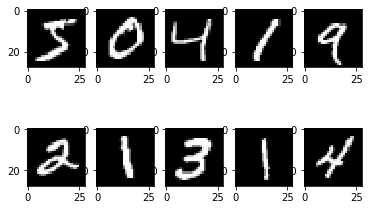

In [21]:
matrix_grid = 10
for i in range(matrix_grid):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray',interpolation="none")

Zobaczmy jak te cyfry są kodowane w `y`:

In [22]:
print(y_train[0:10])

[5 0 4 1 9 2 1 3 1 4]


Do zadań klasyfikacyjnych lepsze jest kodowanie 'one-hot' (na wyjściu mamy wektor o długości liczba klas i 1 na odpowiednim miejscu koduje klasę). Do zmiany kodowania użyjemy funkcji bibliotecznej:

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Zobaczmy co stało się z `y_train`

In [25]:
print(y_train.shape)
print(y_train[0:10])
num_classes = y_test.shape[1]

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


(array([639.,  11.,   6.,  11.,   6.,   9.,  11.,  12.,  11.,  68.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

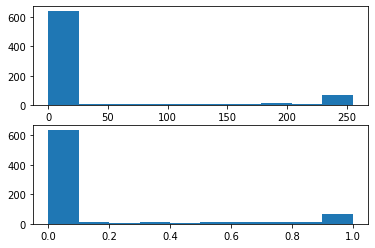

In [26]:
plt.subplot(2,1,1)
plt.hist(X_train[0].flatten())

X_train = X_train / 255
X_test = X_test / 255

plt.subplot(2,1,2)
plt.hist(X_train[0].flatten())

* Zwróć uwagę na zakres skali `x` obu histogramów.

## Klasyfikator: sieć gęsta
Dla tej sieci musimy zmienić kształt wektorów wejściowych. Oryginalnie są one kształtu `28x28`. potrzebujemy je 'spłaszczyć' do kształtu `1x784`:

In [27]:
print("oryginalnie: X_train shape", X_train.shape)
(N_przykladow, N,N) = X_train.shape
print(N)
num_pixels = N*N
print('liczba pikseli w obrazku = ',num_pixels)
X_train = X_train.reshape(X_train.shape[0], num_pixels)
print("po spłaszczeniu: X_train shape", X_train.shape)

oryginalnie: X_train shape (60000, 28, 28)
28
liczba pikseli w obrazku =  784
po spłaszczeniu: X_train shape (60000, 784)


To samo robimy dla zbioru testowego:

In [0]:
X_test = X_test.reshape(X_test.shape[0], num_pixels)

Teraz ładujemy składowe architektury naszej sieci:

In [0]:
from keras.models import Sequential
from keras.layers import Dense

W celu inicjacji modelu używamy konstruktora klasy: Seqiential(). Następnie możemy dodawać interesujące nas struktury, pamiętając o odpowiedniej kolejności. Na początku nasza sieć musi mieć zdefiniowane wymiary wejścia oraz wyjścia - robimy to za pomocą funkcji *Dense*.  

Na początku zajmijmy się charakterystyką wejścia. 
* Pierwszy argument funkcji Dense oznacza liczbę jednostek naszej sieci (w naszym przypadku jest równy rozmiarowi obrazka: 28 * 28, jedna warstwa ukryta). 
* Input_dim to wymiar wejścia, w naszym przypadku płaska macierz mająca 728 pixeli. 
* Kernel_initializer informuje nas w jaki sposób zamierzamy zainicjować macierz wag, ustawienie parametru na wartość random_normal gwarantuje losowani wag z rozkładu normalnego: N(0, 1/2). 
* Argument activation oznacza funkcję aktywacji. 
  * Wybieramy ReLU:                $\quad f(x) = \max(0, x)$

In [0]:
model = Sequential() 
N_jednostek = 256#num_pixels
model.add(Dense(N_jednostek,
                    input_dim = num_pixels,
                    kernel_initializer='normal',
                    activation='relu'))

Teraz zajmiemy się charakterystyką wyjścia. 
* Jako pierwszy argument przekazujemy wymiar wartwy wyjściowej - u nas będzie to liczba klas. 
* Tym razem jako aktywacje dajemy softmax - na wyjściu chcemy mieć wektor prawdopodobieństw przynależności do jednej z dziesięciu klas. 

In [0]:
model.add(Dense(num_classes,
                    kernel_initializer='normal',
                    activation='softmax'))

Policzmy ile parametrów ma nasz model:

In [44]:
model.count_params()

203530

Zobaczmy jego strukturę:

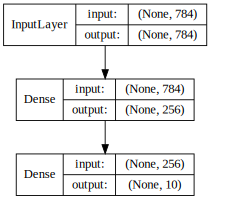

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
tmp = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg')
SVG(tmp)

Tak zdefiniowaną sieć wraz z jej architekturą musimy teraz skompilować.
Najważniejsze argumenty to: 
* loss - funkcja którą będziemy optymalizować, 
* optimizer - funkcja, której użyjemy do optymalizacji, 
* metrics - metryka, według której ocenimy jakość modelu. 

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Teraz będziemy uczyć model. Do metody *fit* obiektu model podajemy:
* ciąg uczący, 
* zbiór walidacyjny, 
* liczbę epok (przejść przez zbiór uczący, osiągnięcie pożądanej wartości błędu wymaga czasem przejścia przez cały ciąg uczący kilka razy), 
* batchsize (liczba próbek po której następuje update gradientu, skraca czas uczenia), 
* varbose - typ informacji wyświetlanych w czasie uczenia (0 - nic, 1 - progress bar, 2 - linia per epoch)

In [47]:
fit = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs = 20, batch_size = 200,
          verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.3856 - acc: 0.8988 - val_loss: 0.1989 - val_acc: 0.9425
Epoch 2/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.1662 - acc: 0.9525 - val_loss: 0.1342 - val_acc: 0.9601
Epoch 3/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.1162 - acc: 0.9675 - val_loss: 0.1054 - val_acc: 0.9691
Epoch 4/20
60000/60000 [==============================] - 3s 43us/step - loss: 0.0885 - acc: 0.9746 - val_loss: 0.0933 - val_acc: 0.9737
Epoch 5/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0702 - acc: 0.9802 - val_loss: 0.0860 - val_acc: 0.9749
Epoch 6/20
60000/60000 [==============================] - 3s 45us/step - loss: 0.0571 - acc: 0.9839 - val_loss: 0.0743 - val_acc: 0.9777
Epoch 7/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0470 - acc: 0.9867 - val_loss: 0.0701 - val_acc

## Zobaczmy historię funkcji błędu i dokładności 

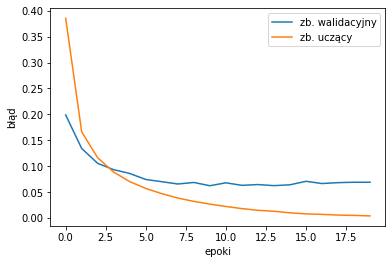

In [48]:
plt.figure()
plt.plot(fit.history['val_loss'] )# na zbiorze walidacyjnym
plt.plot(fit.history['loss'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('błąd')
plt.show()

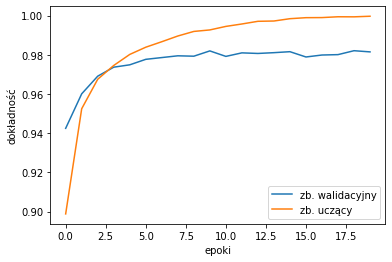

In [49]:
plt.figure()
plt.plot(fit.history['val_acc'] )# na zbiorze walidacyjnym
plt.plot(fit.history['acc'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('dokładność')
plt.show()

In [50]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Błąd na zbiorze testowym: %.2f%%" % (100-scores[1]*100))

Błąd na zbiorze testowym: 1.85%


### Zobaczmy jak wygląda macierz pomyłek na zbiorze testowym:

In [51]:
y_pred = model.predict(X_test)
print(y_pred)

[[1.7719607e-09 3.2105821e-10 3.0990179e-08 ... 9.9993241e-01
  2.4305875e-08 2.8581039e-06]
 [1.2896084e-11 1.7368102e-07 9.9999928e-01 ... 6.5610270e-18
  4.8404786e-07 5.4606965e-18]
 [3.4015812e-09 9.9950218e-01 9.1820468e-05 ... 9.7401709e-05
  3.0541187e-04 8.7015685e-08]
 ...
 [2.2005320e-17 6.4110848e-15 2.3710609e-17 ... 7.3172992e-09
  4.4614894e-09 4.1470507e-08]
 [1.4873546e-12 8.1436479e-16 1.5910281e-15 ... 2.1386881e-12
  1.8145258e-06 1.7948973e-15]
 [1.0388692e-13 8.4413324e-16 1.1261483e-11 ... 4.6831616e-20
  8.0944840e-15 2.0648541e-15]]


Widać, że dostaliśmy prawdopodobieństwa przynależności do każdej z klas (warstwa wyjściowa to softmax). Na potrzeby policzenia macierzy pomyłek sprawdzimy dla każdego przykładu, która klasa jest najbardziej prawdopodobna:

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(y_pred,axis =1))
print(cm)

[[ 967    0    1    0    1    1    3    1    4    2]
 [   0 1125    3    1    0    1    2    1    2    0]
 [   2    0 1012    4    1    0    2    4    6    1]
 [   0    0    2  991    0    5    0    2    4    6]
 [   1    0    1    1  966    0    3    1    1    8]
 [   2    0    0   12    1  868    2    1    4    2]
 [   4    1    2    1    2    6  940    0    2    0]
 [   0    4   10    3    0    0    0 1003    1    7]
 [   1    0    4    3    4    1    1    3  955    2]
 [   0    2    0    4    8    3    1    1    2  988]]


## Wybierzmy kilka przykładów ze zbioru walidacyjnego, które zostały niepoprawnie sklasyfikowane przez naszą sieć

In [0]:
predict = model.predict_classes(X_test)
miss_classified = np.unique(
                    np.nonzero(to_categorical(predict) != y_test)[0])



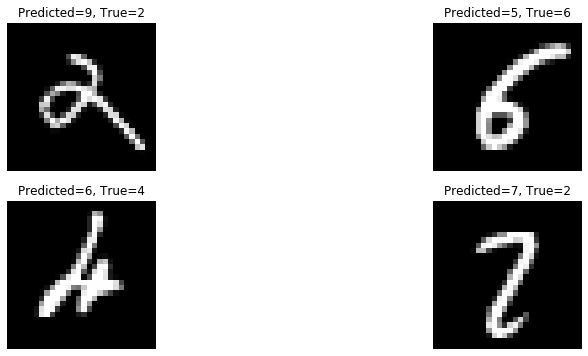

In [54]:
for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(predict[incorrect], np.nonzero(y_test[incorrect])[0][0]))
    plt.axis("off")

# Wersja z siecią konwolucyjną

Żeby poprawnie zbudować sieć konwolucyjną musimy w inny sposób poukładać dane w przykładach. Wczytajmy je zatem i przekształćmy raz jeszcze.
* Kolejne wymiary oznaczają teraz: 
  * liczbę obserwacji, 
  * kanał koloru (ustawiony jako 1 bo mamy tylko odcień szarości. Dla obrazka kolorowego byłoby 3 (RGB)),
  * szerokość ,
  * wysokość obrazka.
  
Reszta przekształceń (kategoryzacja, zmian zakresu zmienności) pozostaje bez zmian.

In [56]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
X_train = X_train / 255
X_test = X_test / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]
print('Kształt macierzy z wejściami: ',X_train.shape)
print('Kształt wektorów wyjściowych: ', y_train.shape)

Kształt macierzy z wejściami:  (60000, 1, 28, 28)
Kształt wektorów wyjściowych:  (60000, 10)


* ustawiamy orientację obrazków dla tensorflow: (https://keras.io/backend/)

In [0]:
from keras import backend as K
K.set_image_data_format('channels_first')

## Zbudujmy sieć o nastepującej architekturze:
* warstwa konwolucyjna - 8 filtrów 3 x 3  (zatem wyjście: (28 - 3) / 1 + 1 = 26
* warstwa zwężająca MaxPooling2D (przemieszczamy się po warstwie konwolucyjnej filtrem 2x2 i wybieramy max). Zmniejszamy wymiarowość warstwy. Redukujemy podatność na przeuczenie. Należy pamiętać, że zmniejszanie wymiarowości może odbyć sie kosztem utraty precyzji (używanie zwężania do stweirdzenia czy np. piłka jest na obrazku da dobre rezultaty, ale precyzyjna lokalizaca piłeczki już niekoniecznie ). 
* warstwa Dropout - regularyzacja, zapobiegamy przeuczeniu. Bardzo prosta zasada działania: usuń 20% jednostek (wraz z połączeniami)
* Warstwa Flatten - dostosowujemy wymiary do warstwy FC
* Warstwa Dense - fully conect, output. Jako aktywacje dajemy softmax. Na końcu kompulijemy model. 

Importujemy warstwy:

In [0]:
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, Dropout, Activation, Flatten

Składamy model i kompilujemy go:

In [0]:
model = Sequential()
model.add(Conv2D(10, (3, 3), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Policzmy ile parametrów ma nasz model:

In [61]:
model.count_params()

1003334

Zobaczmy jego strukturę:

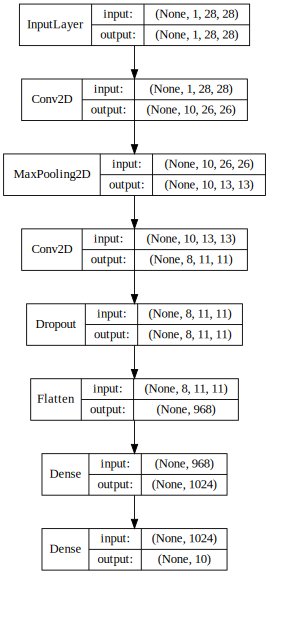

In [81]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
tmp = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg')
SVG(tmp)

In [82]:
fit = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=200, verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 36s 597us/step - loss: 0.2677 - acc: 0.9196 - val_loss: 0.0764 - val_acc: 0.9761
Epoch 2/30
60000/60000 [==============================] - 35s 576us/step - loss: 0.0816 - acc: 0.9753 - val_loss: 0.0483 - val_acc: 0.9846
Epoch 3/30
60000/60000 [==============================] - 35s 581us/step - loss: 0.0567 - acc: 0.9827 - val_loss: 0.0430 - val_acc: 0.9847
Epoch 4/30
60000/60000 [==============================] - 35s 577us/step - loss: 0.0419 - acc: 0.9868 - val_loss: 0.0345 - val_acc: 0.9887
Epoch 5/30
60000/60000 [==============================] - 35s 576us/step - loss: 0.0323 - acc: 0.9898 - val_loss: 0.0295 - val_acc: 0.9910
Epoch 6/30
60000/60000 [==============================] - 35s 577us/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0305 - val_acc: 0.9906
Epoch 7/30
60000/60000 [==============================] - 35s 575us/step - loss: 0.0230 - acc: 0.9922 - val_loss: 0.

## Zobaczmy historię funkcji błędu i dokładności 

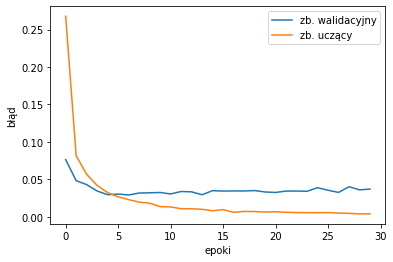

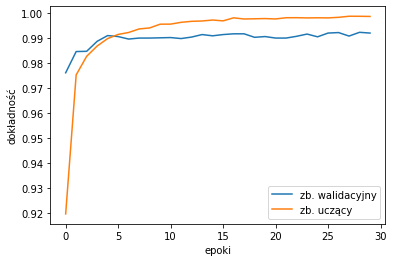

Błąd na zbiorze testowym: 0.80%


In [83]:
plt.figure()
plt.plot(fit.history['val_loss'] )# na zbiorze walidacyjnym
plt.plot(fit.history['loss'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('błąd')
plt.show()

plt.figure()
plt.plot(fit.history['val_acc'] )# na zbiorze walidacyjnym
plt.plot(fit.history['acc'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('dokładność')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Błąd na zbiorze testowym: %.2f%%" % (100-scores[1]*100))

Sprawdźmy macierz pomyłek:

In [84]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(y_pred,axis =1))
print(cm)

[[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1133    0    1    0    0    1    0    0    0]
 [   1    0 1027    0    0    0    1    3    0    0]
 [   0    0    1 1000    0    5    0    1    2    1]
 [   0    0    3    0  970    0    1    0    0    8]
 [   1    0    0    5    0  882    2    0    0    2]
 [   3    3    0    0    1    2  949    0    0    0]
 [   0    1    3    0    0    0    0 1020    1    3]
 [   2    0    3    1    0    0    0    0  967    1]
 [   1    2    0    0    5    1    0    4    1  995]]


## Podobnie jak dla poprzedniego modelu, wyświetlmy kilka źle sklasyfikowanych rekordów

In [0]:
predict = model.predict_classes(X_test)

miss_classified = np.unique(
                    np.nonzero(
                        to_categorical(predict) != y_test)[0])




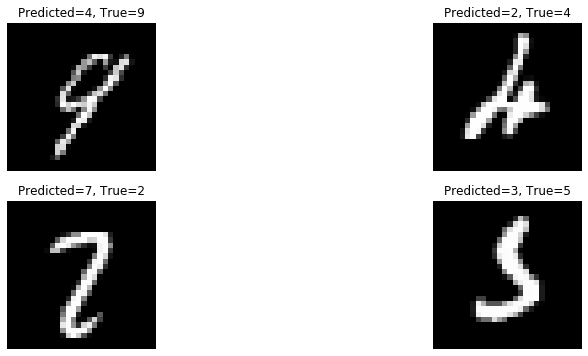

In [86]:
for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(predict[incorrect], np.nonzero(y_test[incorrect])[0][0]))
    plt.axis("off")

## Warto spróbować:##
* Wpływ algorytmu optymalizacyjnego na szybkość uczenia
* Wpływ wielkości batcha na tempo uczenia
* Efekty przeuczenia przy zbyt dużej liczbie parametrów: 
  * ustaw rozmiar warstwy wejściowej w modelu gęstym na 256 -> naucz model i obejrzyj wykresy zbiegania funkji kosztu i miary dokładności dla danych uczących i testowych
  * Wypróbuj inne architektury sieci głębokiej (konwolucyjnej) -> wymyśl własną kombinację warstw i ich parametrów i zbadaj jakość tej architektury
* dla ustalonego modelu zbadaj krzywe uczenia, czyli zależność funkcji kosztu od liczby przykładów uczących na zbiorze uczącym i testowym (to może trochę potrwać ;))

## Zadania na dzisiaj:##
* Porównanie błędu DNN i CNN. Czemu jedno radzi sobie lepiej niż drugie?
* Dokładny opis warstw CNN (własnymi słowami). Źródło: wykład, internet.
* Własny model CNN + trening + zapisać błąd.

Algorytm optymalizacyjny może polepszać szybkość uczenia na epokę ale zwykle kosztem wydłużenia czasu obliczeń. Taki sam wpływ ma zwiększenie rozmiaru batcha. Przeuczenie jest związane ze zbyt dużą liczbą parametrów sieci - sieć dzięki temu może za dobrze dopasować swoje działanie do danych trenujących co ewentuanie powoduje większe błędy na innych danych (np. testowych).

1. W przpadku analizy obrazów ważne jest rozpoznawanie detali - lokalnego ułożenia pikseli w przestrzeni (np. detekcji linii). Jest to informacja lokalna, którą dobrze uzyskać wykonując splot z pewną małą macierzą (jak w sieciach CNN). W przypadku sieci DNN wpływ na ustalenie wag mają wszystkie piksele (sieć CNN "nie widzi" lokalnego ułożenia pikseli; traktuje je wszystkie równorzędnie) więc trudnej jest wyłapywać lokalne związki między pikselami które ze sobą sąsiadują.
2. 

  a) warstwa konwolucyjna - główny składnik sieci CNN. Składa się z zestawu filtrów które mogą sę uczyć (są adaptowalne). Jeśli obraz wejściowy ma kilka kanałów (np. 3 kanały dla RGB) to filtrem jest efektywnie zestaw filtrów dla każdego kanału. Każdy filtr ma jądro (macierz) z którą splatany jest (odpowiedni iloczyn skalarny) obraz wejściowy. Wynikiem jest mapa aktywacji dla danego filtra w każdym kanale. Mapy aktywacji dla danego filtra układane są na stercie wzdłuż wymiaru głębokości sieci i dostajemy obraz wyjściowy (sumę) dla danego filtra. Na wyjściu mmay więc tyle obrazów ile filtrów (tutaj filtr= de facto zestaw N filtrów jak na wejściu mamy N kanałów). Zadaniem tej warstwy jest detekcja detali (lokalnych konfiguracji pikseli).

  b) warsta łącząca - dokokuje tzw. próbkowania przestzrennego czyli np. liczenia max w danym okienku. W efekcie następuje uproszczenie: redukcja liczby danych co przyspiesza obiczenia i zapobiega overfitingowi.

  c) warstwa ReLU - stosuje funkcję aktywacji ReLU (tzn. max(x,0)) z zerowym progiem. Rozmiar danych nie ulega zmianie.

  d) warstwa strat - odrzucamy część neuronów w warstwie razem z połączniami. Przypsiesza obliczenia i zapobiega overfittingowi.

  e) warstwa gęsta - neurony połączone każdy z każdym z sąsiednimi warstwami. Służy do obliczenia wyniku klasyfikacji - redukuje wymiar do wyjściowego (1 neuron = 1 klasa). Jest uczona metodami uczenia nadzorowanego (np. wstecznej propagacji błędów).

3. Zaproponowano architekturę która jest podobna do poprzedniej lecz posiada dodatkową warstwę łączącą. Ponadto zmniejszono liczbę odrzuconych neuronów w warstwie strat do 10%.

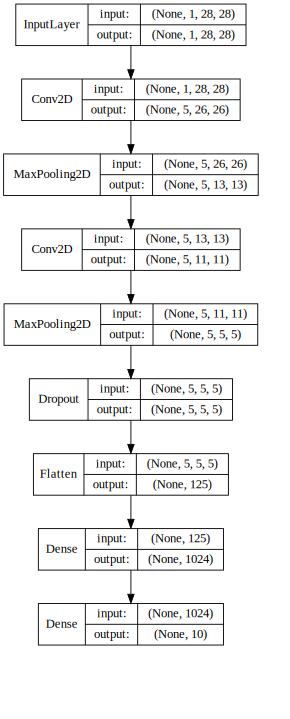

In [69]:
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, Dropout, Activation, Flatten

model = Sequential()
model.add(Conv2D(5, (3, 3), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(5, (3, 3), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.count_params()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
tmp = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg')
SVG(tmp)



Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 22s 372us/step - loss: 0.0106 - acc: 0.9963 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 2/30
60000/60000 [==============================] - 23s 375us/step - loss: 0.0114 - acc: 0.9963 - val_loss: 0.0411 - val_acc: 0.9888
Epoch 3/30
60000/60000 [==============================] - 22s 373us/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0381 - val_acc: 0.9900
Epoch 4/30
60000/60000 [==============================] - 22s 372us/step - loss: 0.0105 - acc: 0.9964 - val_loss: 0.0404 - val_acc: 0.9900
Epoch 5/30
60000/60000 [==============================] - 23s 376us/step - loss: 0.0103 - acc: 0.9964 - val_loss: 0.0368 - val_acc: 0.9908
Epoch 6/30
60000/60000 [==============================] - 22s 371us/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0395 - val_acc: 0.9905
Epoch 7/30
60000/60000 [==============================] - 23s 375us/step - loss: 0.0102 - acc: 0.9967 - val_loss: 0.

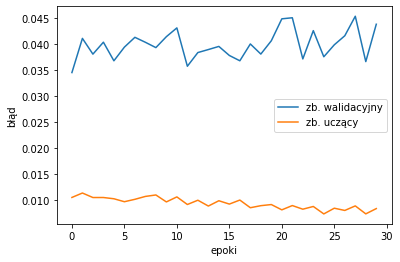

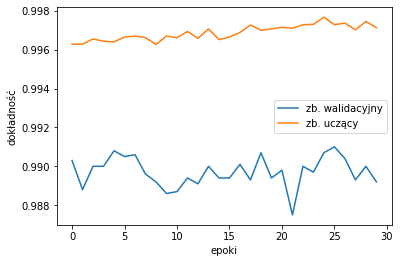

Błąd na zbiorze testowym: 1.08%
[[ 979    0    0    0    0    0    0    1    0    0]
 [   3 1129    0    0    0    1    0    0    1    1]
 [   1    1 1026    1    0    0    0    2    1    0]
 [   1    0    1 1000    0    3    0    1    4    0]
 [   0    0    0    0  967    1    7    1    0    6]
 [   1    0    0    5    0  884    1    1    0    0]
 [   8    3    0    0    0    1  943    0    3    0]
 [   1    1   10    4    0    0    0 1005    3    4]
 [   2    0    2    1    0    1    0    0  968    0]
 [   1    0    0    1    4    2    0    2    8  991]]


In [73]:
fit = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=200, verbose=1)

plt.figure()
plt.plot(fit.history['val_loss'] )# na zbiorze walidacyjnym
plt.plot(fit.history['loss'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('błąd')
plt.show()

plt.figure()
plt.plot(fit.history['val_acc'] )# na zbiorze walidacyjnym
plt.plot(fit.history['acc'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('dokładność')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Błąd na zbiorze testowym: %.2f%%" % (100-scores[1]*100))

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(y_pred,axis =1))
print(cm)

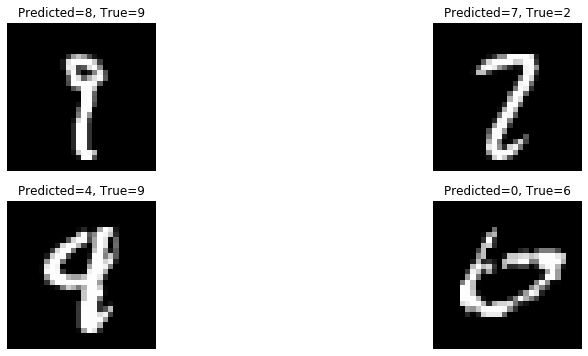

In [71]:
predict = model.predict_classes(X_test)

miss_classified = np.unique(
                    np.nonzero(
                        to_categorical(predict) != y_test)[0])

for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(predict[incorrect], np.nonzero(y_test[incorrect])[0][0]))
    plt.axis("off")